In [1]:
push!(LOAD_PATH, "../../src")
using FCA
using Colors, Images, FileIO, Plots, Statistics, LinearAlgebra

┌ Info: Recompiling stale cache file /Users/haowurm/.julia/compiled/v1.0/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1190


┌ Info: Recompiling stale cache file /Users/haowurm/.julia/compiled/v1.0/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1190


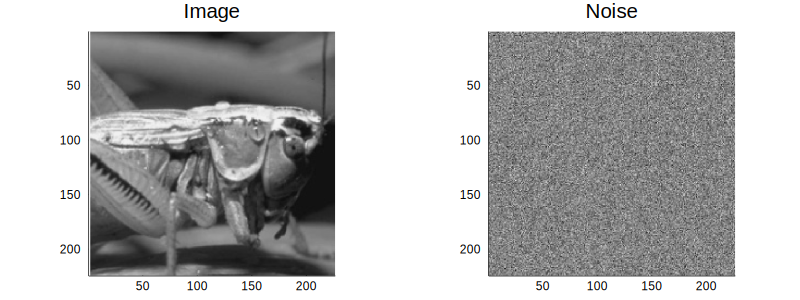

In [2]:
# import the panda image
image = "../images/locust.jpg"; # also try images/locust.jpg
I1 = Float64.(Gray.(load(image)))

# generate the white noise, match the variance
I2 = randn(size(I1))*std(I1)

# plot the original image and noise
p1 = heatmap(I1, yflip=true, color=:grays, aspect_ratio=:equal, title="Image", colorbar = false)
p2 = heatmap(I2, yflip=true, color=:grays, aspect_ratio=:equal, title="Noise", colorbar = false)
plot(p1, p2; size=(800, 300))

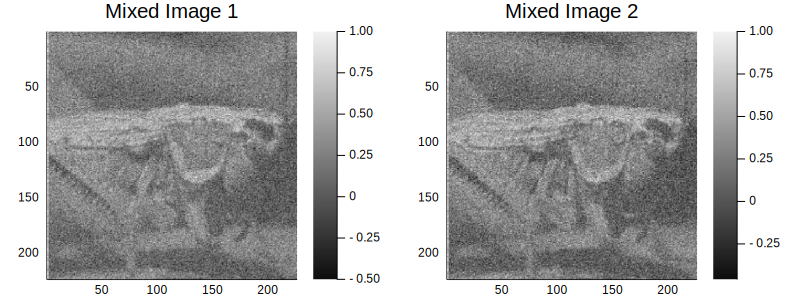

In [3]:
# Noise image
X = [I1, I2]
I1 = 0.0
I2 = 0.0 ## this clears I1 and I2 from memory

# mixing matrix
A = [0.5 0.5; 0.5 -0.5]
Z = A*X

# normalize the mixed images for plot
mixed1 = Z[1]/maximum(Z[1])
mixed2 = Z[2]/maximum(Z[2])

# plot the mixed images
p3 = heatmap(mixed1, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 1")
p4 = heatmap(mixed2, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 2")

# release the memory
mixed1, mixed2 = 0.0, 0.0

# show the plot
plot(p3, p4; size=(800, 300))

## Denoise image using icf

In [4]:
# using icf to denoise image
# reshape mixed images to vector
z = [vec(Z[i]) for i = 1: 2]

# apply icf
Aica, xica = icf(z)

([-0.0760721 -0.140812; -0.141539 0.0761495], Array{Float64,1}[[-3.76375, -4.55396, -3.83054, -4.45079, -4.09407, -4.24722, -4.01235, -3.69326, -3.70115, -3.71543  …  -1.82297, -2.32232, -2.60758, -1.39187, -1.70074, -2.16278, -1.84927, -1.60238, -1.19726, -1.64999], [-2.79866, -0.139318, -2.57389, -0.486523, -1.687, -1.11098, -1.96203, -3.03586, -3.00931, -2.96126  …  -1.74917, 0.355811, 1.5584, -2.16896, -0.826299, 0.910553, 0.0980826, -0.126301, -0.822567, 1.1862]])

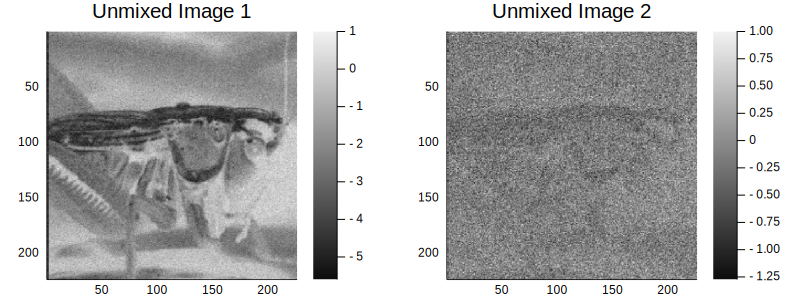

In [5]:
# normalize the unmixed images
unmixed1ica = reshape(xica[1]/maximum(xica[1]), size(Z[1]))
unmixed2ica = reshape(xica[2]/maximum(xica[2]), size(Z[1]))

# Plot the denoised image by icf, note that there is still some noise left.
p5 = heatmap(unmixed1ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p6 = heatmap(unmixed2ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")
plot(p5, p6; layout=2, size=(800, 300))

  3.305542 seconds (2.23 M allocations: 885.382 MiB, 12.55% gc time)


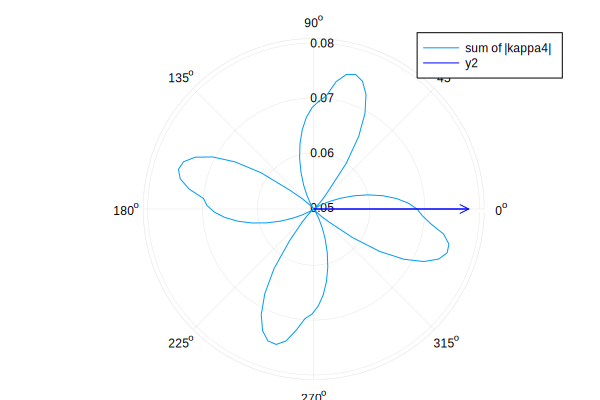

In [6]:
# the direction found by maximize sum of absolute value of free kurtosis
# does recover the independent component
# whiten the original images sepearately 
x = [vec(X[1]), vec(X[2])]
x = [x[i] .- mean(x[i]) for i = 1: 2]
x = [x[i] / std(x[i]) for i = 1: 2]

# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 100)
@time plot(θ -> -neg_abs_sum_kurt([cos(θ) sin(θ); -sin(θ) cos(θ)]*x), 
    θ_range, proj=:polar, label="sum of |kappa4|")
y1, y2 = ylims()
plot!([0, 0], [y1, y2], seriestype=:path, proj=:polar, arrow=0.2, color=:blue)

## Denoise image using fcf

  9.883334 seconds (5.29 M allocations: 1.360 GiB, 4.24% gc time)


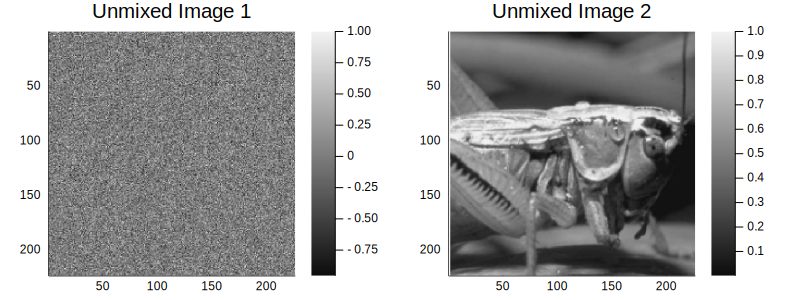

In [7]:
# Apply kurtosis-based freecf to unmix the images
@time Afca, Xfca = freecf(Z; mat = "rec")
 
# normalized the unmixed images 
unmixed1fca = Xfca[1]/maximum(Xfca[1])
unmixed2fca = Xfca[2]/maximum(Xfca[2])

# plot the unmixed images
p7 = heatmap(unmixed1fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p8 = heatmap(unmixed2fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")

unmixed1fca = 0.0
unmixed2fca = 0.0

# show the unmixed images, compare it with icf result
plot(p7, p8; layout=2, size=(800, 300))